In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *

In [4]:
# read in selection matrices for each luminosity selected sample 

data_smatrix03 = np.load('/Users/mtownsend/Desktop/lowz_smatrix-2matrices.npz')
smatrix03 = data_smatrix03['smatrix_low']
print(smatrix03.shape)

data_smatrix04 = np.load('/Users/mtownsend/Desktop/midz1_smatrix-4matrices.npz')
smatrix04 = data_smatrix04['smatrix_low']
print(smatrix04.shape)

data_smatrix05 = np.load('/Users/mtownsend/Desktop/midz2_smatrix-6matrices.npz')
smatrix05 = data_smatrix05['smatrix_low']
print(smatrix05.shape)

data_smatrix06 = np.load('/Users/mtownsend/Desktop/midz3_smatrix-8matrices.npz')
smatrix06 = data_smatrix06['smatrix_low']
print(smatrix06.shape)

data_smatrix65 = np.load('/Users/mtownsend/Desktop/highz_smatrix-9matrices.npz')
smatrix65 = data_smatrix65['smatrix_low']
print(smatrix65.shape)

(2, 49, 49, 49)
(4, 49, 49, 49)
(6, 49, 49, 49)
(8, 49, 49, 49)
(9, 49, 49, 49)


In [5]:
# read in unmasked data results

data_Nsat25 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat25_unmasked.npz')
Nsat_data25 = data_Nsat25['Nsat25']
print(Nsat_data25.shape)

data_Nsat03 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat03_unmasked.npz')
Nsat_data03 = data_Nsat03['Nsat03']
print(Nsat_data03.shape)

data_Nsat35 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat35_unmasked.npz')
Nsat_data35 = data_Nsat35['Nsat35']
print(Nsat_data35.shape)

data_Nsat04 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat04_unmasked.npz')
Nsat_data04 = data_Nsat04['Nsat04']
print(Nsat_data04.shape)

data_Nsat45 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat45_unmasked.npz')
Nsat_data45 = data_Nsat45['Nsat45']
print(Nsat_data45.shape)

data_Nsat05 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat05_unmasked.npz')
Nsat_data05 = data_Nsat05['Nsat05']
print(Nsat_data05.shape)

data_Nsat55 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat55_unmasked.npz')
Nsat_data55 = data_Nsat55['Nsat55']
print(Nsat_data55.shape)

data_Nsat06 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat06_unmasked.npz')
Nsat_data06 = data_Nsat06['Nsat06']
print(Nsat_data06.shape)

data_Nsat65 = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nsat65_unmasked.npz')
Nsat_data65 = data_Nsat65['Nsat65']
print(Nsat_data65.shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)
(386, 49, 49, 49)
(325, 49, 49, 49)
(186, 49, 49, 49)


In [6]:
# make masked Nsat for log(lum)=9.55; 0.2 < z < 0.3

# 0.2 < z < 0.25
lowz_maskedNsat25 = []
for i in range(len(Nsat_data25)):
    lowz_maskedNsat25.append(Nsat_data25[i] * smatrix03[0])
    
# 0.25 < z < 0.3
lowz_maskedNsat03 = []
for i in range(len(Nsat_data03)):
    lowz_maskedNsat03.append(Nsat_data03[i] * smatrix03[1])

print(np.asarray(lowz_maskedNsat25).shape)
print(np.asarray(lowz_maskedNsat03).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)


In [7]:
# make masked Nsat for log(lum)=9.84; 0.2 < z < 0.4

# 0.2 < z < 0.25
mid1_maskedNsat25 = []
for i in range(len(Nsat_data25)):
    mid1_maskedNsat25.append(Nsat_data25[i] * smatrix04[0])
    
# 0.25 < z < 0.3
mid1_maskedNsat03 = []
for i in range(len(Nsat_data03)):
    mid1_maskedNsat03.append(Nsat_data03[i] * smatrix04[1])
    
# 0.3 < z < 0.35
mid1_maskedNsat35 = []
for i in range(len(Nsat_data35)):
    mid1_maskedNsat35.append(Nsat_data35[i] * smatrix04[2])
    
# 0.35 < z < 0.4
mid1_maskedNsat04 = []
for i in range(len(Nsat_data04)):
    mid1_maskedNsat04.append(Nsat_data04[i] * smatrix04[3])


print(np.asarray(mid1_maskedNsat25).shape)
print(np.asarray(mid1_maskedNsat03).shape)
print(np.asarray(mid1_maskedNsat35).shape)
print(np.asarray(mid1_maskedNsat04).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)


In [8]:
# make masked Nsat for log(lum)=10.13; 0.2 < z < 0.5

# 0.2 < z < 0.25
mid2_maskedNsat25 = []
for i in range(len(Nsat_data25)):
    mid2_maskedNsat25.append(Nsat_data25[i] * smatrix05[0])
    
# 0.25 < z < 0.3
mid2_maskedNsat03 = []
for i in range(len(Nsat_data03)):
    mid2_maskedNsat03.append(Nsat_data03[i] * smatrix05[1])
    
# 0.3 < z < 0.35
mid2_maskedNsat35 = []
for i in range(len(Nsat_data35)):
    mid2_maskedNsat35.append(Nsat_data35[i] * smatrix05[2])
    
# 0.35 < z < 0.4
mid2_maskedNsat04 = []
for i in range(len(Nsat_data04)):
    mid2_maskedNsat04.append(Nsat_data04[i] * smatrix05[3])
    
# 0.4 < z < 0.45
mid2_maskedNsat45 = []
for i in range(len(Nsat_data45)):
    mid2_maskedNsat45.append(Nsat_data45[i] * smatrix05[4])
    
# 0.45 < z < 0.5
mid2_maskedNsat05 = []
for i in range(len(Nsat_data05)):
    mid2_maskedNsat05.append(Nsat_data05[i] * smatrix05[5])


print(np.asarray(mid2_maskedNsat25).shape)
print(np.asarray(mid2_maskedNsat03).shape)
print(np.asarray(mid2_maskedNsat35).shape)
print(np.asarray(mid2_maskedNsat04).shape)
print(np.asarray(mid2_maskedNsat45).shape)
print(np.asarray(mid2_maskedNsat05).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)


In [9]:
# make masked Nsat for log(lum)=10.36; 0.2 < z < 0.6

# 0.2 < z < 0.25
mid3_maskedNsat25 = []
for i in range(len(Nsat_data25)):
    mid3_maskedNsat25.append(Nsat_data25[i] * smatrix06[0])
    
# 0.25 < z < 0.3
mid3_maskedNsat03 = []
for i in range(len(Nsat_data03)):
    mid3_maskedNsat03.append(Nsat_data03[i] * smatrix06[1])
    
# 0.3 < z < 0.35
mid3_maskedNsat35 = []
for i in range(len(Nsat_data35)):
    mid3_maskedNsat35.append(Nsat_data35[i] * smatrix06[2])
    
# 0.35 < z < 0.4
mid3_maskedNsat04 = []
for i in range(len(Nsat_data04)):
    mid3_maskedNsat04.append(Nsat_data04[i] * smatrix06[3])
    
# 0.4 < z < 0.45
mid3_maskedNsat45 = []
for i in range(len(Nsat_data45)):
    mid3_maskedNsat45.append(Nsat_data45[i] * smatrix06[4])
    
# 0.45 < z < 0.5
mid3_maskedNsat05 = []
for i in range(len(Nsat_data05)):
    mid3_maskedNsat05.append(Nsat_data05[i] * smatrix06[5])
    
# 0.5 < z < 0.55
mid3_maskedNsat55 = []
for i in range(len(Nsat_data55)):
    mid3_maskedNsat55.append(Nsat_data55[i] * smatrix06[6])
    
# 0.55 < z < 0.6
mid3_maskedNsat06 = []
for i in range(len(Nsat_data06)):
    mid3_maskedNsat06.append(Nsat_data06[i] * smatrix06[7])


print(np.asarray(mid3_maskedNsat25).shape)
print(np.asarray(mid3_maskedNsat03).shape)
print(np.asarray(mid3_maskedNsat35).shape)
print(np.asarray(mid3_maskedNsat04).shape)
print(np.asarray(mid3_maskedNsat45).shape)
print(np.asarray(mid3_maskedNsat05).shape)
print(np.asarray(mid3_maskedNsat55).shape)
print(np.asarray(mid3_maskedNsat06).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)
(386, 49, 49, 49)
(325, 49, 49, 49)


In [10]:
# make masked Nsat for log(lum)=10.47; 0.2 < z < 0.65

# 0.2 < z < 0.25
high_maskedNsat25 = []
for i in range(len(Nsat_data25)):
    high_maskedNsat25.append(Nsat_data25[i] * smatrix65[0])
    
# 0.25 < z < 0.3
high_maskedNsat03 = []
for i in range(len(Nsat_data03)):
    high_maskedNsat03.append(Nsat_data03[i] * smatrix65[1])
    
# 0.3 < z < 0.35
high_maskedNsat35 = []
for i in range(len(Nsat_data35)):
    high_maskedNsat35.append(Nsat_data35[i] * smatrix65[2])
    
# 0.35 < z < 0.4
high_maskedNsat04 = []
for i in range(len(Nsat_data04)):
    high_maskedNsat04.append(Nsat_data04[i] * smatrix65[3])
    
# 0.4 < z < 0.45
high_maskedNsat45 = []
for i in range(len(Nsat_data45)):
    high_maskedNsat45.append(Nsat_data45[i] * smatrix65[4])
    
# 0.45 < z < 0.5
high_maskedNsat05 = []
for i in range(len(Nsat_data05)):
    high_maskedNsat05.append(Nsat_data05[i] * smatrix65[5])
    
# 0.5 < z < 0.55
high_maskedNsat55 = []
for i in range(len(Nsat_data55)):
    high_maskedNsat55.append(Nsat_data55[i] * smatrix65[6])
    
# 0.55 < z < 0.6
high_maskedNsat06 = []
for i in range(len(Nsat_data06)):
    high_maskedNsat06.append(Nsat_data06[i] * smatrix65[7])

# 0.6 < z < 0.65
high_maskedNsat65 = []
for i in range(len(Nsat_data65)):
    high_maskedNsat65.append(Nsat_data65[i] * smatrix65[8])


print(np.asarray(high_maskedNsat25).shape)
print(np.asarray(high_maskedNsat03).shape)
print(np.asarray(high_maskedNsat35).shape)
print(np.asarray(high_maskedNsat04).shape)
print(np.asarray(high_maskedNsat45).shape)
print(np.asarray(high_maskedNsat05).shape)
print(np.asarray(high_maskedNsat55).shape)
print(np.asarray(high_maskedNsat06).shape)
print(np.asarray(high_maskedNsat65).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)
(386, 49, 49, 49)
(325, 49, 49, 49)
(186, 49, 49, 49)


In [11]:
# edges for function

rz_edges = np.array([-1.8536053, -1.6036052703857422, -1.3536052703857422, -1.1036052703857422, -0.8536052703857422, -0.6036052703857422, -0.3536052703857422, -0.10360527038574219, 0.1463947296142578, 0.3963947296142578, 0.6463947296142578, 0.8963947296142578, 1.1463947296142578, 1.3963947296142578, 1.6463947296142578, 1.8963947296142578, 2.146394729614258, 2.396394729614258, 2.646394729614258, 2.896394729614258, 3.146394729614258, 3.396394729614258, 3.646394729614258, 3.896394729614258, 4.146394729614258, 4.396394729614258, 4.646394729614258, 4.896394729614258, 5.146394729614258, 5.396394729614258, 5.646394729614258, 5.896394729614258, 6.146394729614258, 6.396394729614258, 6.646394729614258, 6.896394729614258, 7.146394729614258, 7.396394729614258, 7.646394729614258, 7.896394729614258, 8.146394729614258, 8.396394729614258, 8.646394729614258, 8.896394729614258, 9.146394729614258, 9.396394729614258, 9.646394729614258, 9.896394729614258, 10.146394729614258, 10.396394729614258])
zmag_edges = np.array([13.163162, 13.363162231445312, 13.563162231445311, 13.76316223144531, 13.96316223144531, 14.163162231445309, 14.363162231445308, 14.563162231445308, 14.763162231445307, 14.963162231445306, 15.163162231445305, 15.363162231445305, 15.563162231445304, 15.763162231445303, 15.963162231445303, 16.163162231445302, 16.3631622314453, 16.5631622314453, 16.7631622314453, 16.9631622314453, 17.1631622314453, 17.363162231445298, 17.563162231445297, 17.763162231445296, 17.963162231445295, 18.163162231445295, 18.363162231445294, 18.563162231445293, 18.763162231445293, 18.963162231445292, 19.16316223144529, 19.36316223144529, 19.56316223144529, 19.76316223144529, 19.96316223144529, 20.163162231445288, 20.363162231445287, 20.563162231445286, 20.763162231445285, 20.963162231445285, 21.163162231445284, 21.363162231445283, 21.563162231445283, 21.763162231445282, 21.96316223144528, 22.16316223144528, 22.36316223144528, 22.56316223144528, 22.76316223144528, 22.963162231445278])
gr_edges = np.array([-6.673929, -6.323929214477539, -5.97392921447754, -5.62392921447754, -5.2739292144775405, -4.923929214477541, -4.573929214477541, -4.2239292144775415, -3.8739292144775415, -3.5239292144775414, -3.1739292144775413, -2.823929214477541, -2.473929214477541, -2.123929214477541, -1.773929214477541, -1.4239292144775408, -1.0739292144775408, -0.7239292144775408, -0.3739292144775408, -0.023929214477540817, 0.32607078552245916, 0.6760707855224591, 1.0260707855224591, 1.376070785522459, 1.726070785522459, 2.076070785522459, 2.4260707855224592, 2.7760707855224593, 3.1260707855224594, 3.4760707855224595, 3.8260707855224596, 4.17607078552246, 4.526070785522459, 4.876070785522459, 5.226070785522459, 5.576070785522458, 5.926070785522458, 6.276070785522458, 6.626070785522457, 6.976070785522457, 7.3260707855224565, 7.676070785522456, 8.026070785522457, 8.376070785522456, 8.726070785522456, 9.076070785522456, 9.426070785522455, 9.776070785522455, 10.126070785522455, 10.476070785522454])

edges = np.array([rz_edges, zmag_edges, gr_edges])
print(edges.shape)


(3, 50)


In [16]:
# the redshift, rzcolor, and zmag of LRGs

data_zmagLRG = np.load('/Users/mtownsend/Documents/LRG_Data/zmag_LRG.npz')
zmagLRG = data_zmagLRG['zmag_LRG']
print(zmagLRG.shape)

data_rzcolorLRG = np.load('/Users/mtownsend/Documents/LRG_Data/rzcolor_LRG.npz')
rzcolorLRG = data_rzcolorLRG['rzcolor_LRG']
print(rzcolorLRG.shape)

data_zLRG = np.load('/Users/mtownsend/Documents/LRG_Data/z_LRG.npz')
zLRG = data_zLRG['z_LRG']
print(zLRG.shape)

(1823,)
(1823,)
(1823,)


In [54]:
def cmdHistograms(H, edges, zmag_LRG, z_LRG, rzcolor_LRG):

    # This function plots a color-magnitude 2D histogram for satellites around LRG; produces a histogram for every LRG

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors

    plt.rcParams.update({'figure.max_open_warning': 0})

    rz_zmag_sum = list(np.zeros((49,49)))
#     gr_zmag_sum = list(np.zeros((49,49)))
#     gr_rz_sum = list(np.zeros((49,49)))
    for i in range(len(H)):
        # make 2D projections of 3D histogram
        rz_v_zmag = H[i][:, :, :].sum(axis=2)
        rz_vs_zmag = np.flipud(rz_v_zmag)
        rz_zmag_sum = np.add(rz_zmag_sum, rz_vs_zmag)
#         gr_v_zmag = H[i][:, :, :].sum(axis=0)
#         gr_vs_zmag = np.flipud(gr_v_zmag.T)
#         gr_zmag_sum = np.add(gr_zmag_sum, gr_vs_zmag)
#         gr_v_rz = H[i][:, :, :].sum(axis=1)
#         gr_vs_rz = np.flipud(gr_v_rz.T)
#         gr_rz_sum = np.add(gr_rz_sum, gr_vs_rz)
        

        # plot 2D histograms using matshow; 3 plots per image
#         f, axarr = plt.subplots(111, figsize=(10, 10))
#         f.suptitle("Satellite Density CMD (LRG {})".format(i))

    plt.rcParams["figure.figsize"] = [40, 10]
    im1 = plt.matshow(rz_zmag_sum, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[1][0], edges[1][len(edges[1]) - 1], edges[0][0], edges[0][len(edges[0]) - 1]])
    plt.scatter(zmag_LRG[np.where((z_LRG >= 0.2) & (z_LRG < 0.65))], rzcolor_LRG[np.where((z_LRG >= 0.2) & (z_LRG < 0.65))], s=4, color='red', label="LRG")
    plt.title("Satellite Color-Magnitude Diagram (0.2 > z > 0.65)".format(i), fontsize=20, pad=20)
#         plt.xaxis.set_ticks_position('bottom')
#         plt.invert_xaxis()
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    plt.gca().invert_xaxis()
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim(22.36, 16)
    plt.ylim(-1, 3)
#         plt.set(xlabel='zmag', ylabel='(r-z)')
#         plt.set_ylim(bottom=-5, top=5)
    plt.colorbar(im1, orientation="horizontal", fraction=0.037, pad=0.07)
#         s = 'LRG redshift: {0:.2f}'.format(z_LRG[i])
#         t = 'LRG coords: {:.2f}, {:.2f}'.format(ra_LRG[i], dec_LRG[i])
#         plt.text(16, -2, s, family='sans-serif', fontsize=14)
#         plt.text(16, -2.5, t, family='sans-serif', fontsize=14)
#         axarr[0].title("Satellite Color-Magnitude Diagram (LRG {})".format(i), fontsize=15)
    plt.xlabel(r'$z-mag$', fontsize=20)
    plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
    plt.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

        # save image with incrementing file name
    plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Nov2020/high_satHistCMD.pdf')    
    plt.show()
    
# cmdHistograms(Nsat_zcut1, edges)
# cmdHistograms(Nsat_zcut2, edges)
# cmdHistograms(Nsat_zcut3, edges)
# cmdHistograms(Nsat_zcut4, edges)
# cmdHistograms(Nsat_zcut5, edges)


# sns.jointplot(Nsat_zcut5, edges, kind="hex", color="#4CB391")


In [37]:
lowz_Nsat = lowz_maskedNsat25 + lowz_maskedNsat03
print(np.asarray(lowz_maskedNsat25).shape)
print(np.asarray(lowz_maskedNsat03).shape)
print(np.asarray(lowz_Nsat).shape)

mid1_Nsat = mid1_maskedNsat25 + mid1_maskedNsat03 + mid1_maskedNsat35 + mid1_maskedNsat04

mid2_Nsat = mid2_maskedNsat25 + mid2_maskedNsat03 + mid2_maskedNsat35 + mid2_maskedNsat04 + mid2_maskedNsat45 + mid2_maskedNsat05

mid3_Nsat = mid3_maskedNsat25 + mid3_maskedNsat03 + mid3_maskedNsat35 + mid3_maskedNsat04 + mid3_maskedNsat45 + mid3_maskedNsat05 + mid3_maskedNsat55 + mid3_maskedNsat06

high_Nsat = high_maskedNsat25 + high_maskedNsat03 + high_maskedNsat35 + high_maskedNsat04 + high_maskedNsat45 + high_maskedNsat05 + high_maskedNsat55 + high_maskedNsat06 + high_maskedNsat65



(90, 49, 49, 49)
(83, 49, 49, 49)
(173, 49, 49, 49)


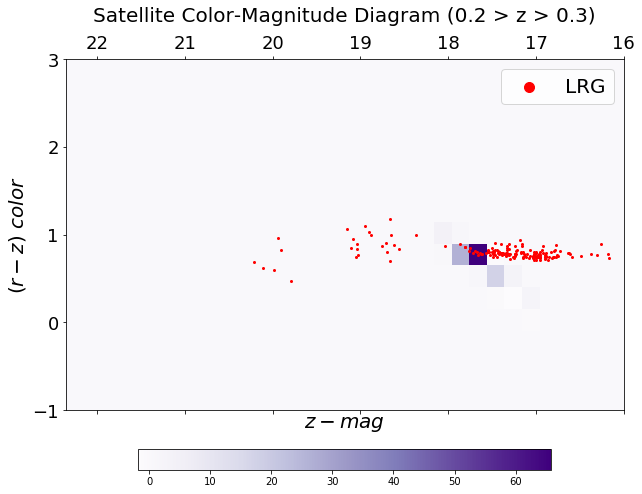

In [47]:
cmdHistograms(lowz_Nsat, edges, zmagLRG, zLRG, rzcolorLRG)


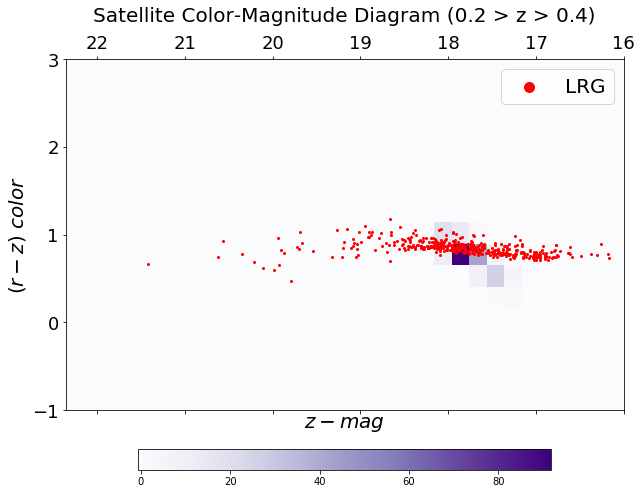

In [49]:
cmdHistograms(mid1_Nsat, edges, zmagLRG, zLRG, rzcolorLRG)


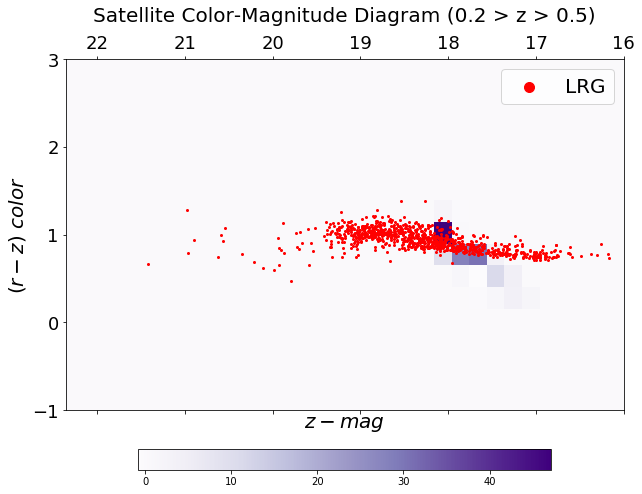

In [51]:
cmdHistograms(mid2_Nsat, edges, zmagLRG, zLRG, rzcolorLRG)


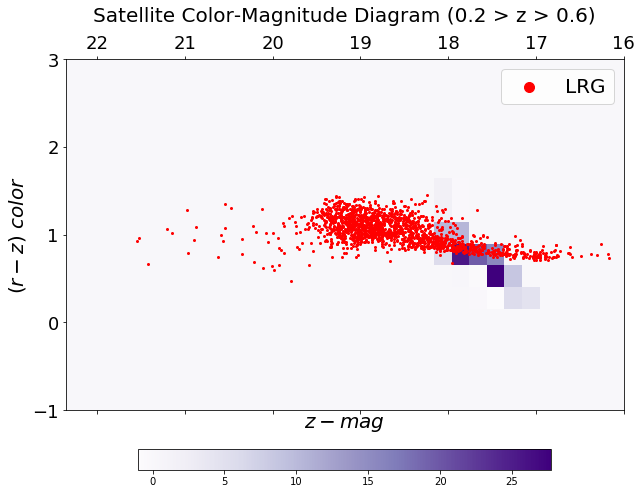

In [53]:
cmdHistograms(mid3_Nsat, edges, zmagLRG, zLRG, rzcolorLRG)


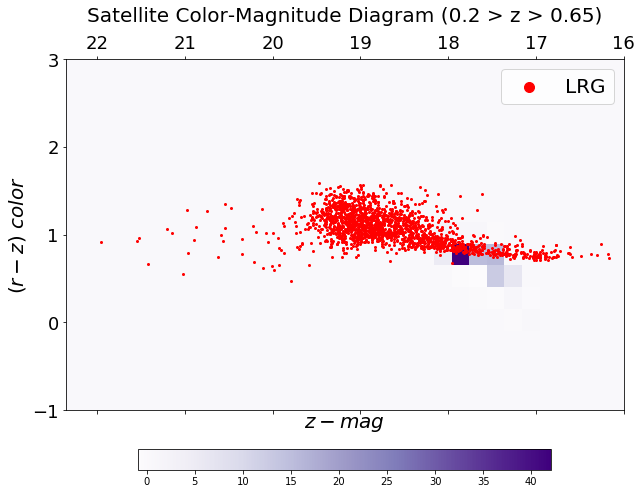

In [55]:
cmdHistograms(high_Nsat, edges, zmagLRG, zLRG, rzcolorLRG)
